In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt

import copy

from pytorch_datasetloader import *

# The Discriminator

In [2]:
class Dis(nn.Module):
    
    
    def __init__(self):
        
        super().__init__()
        
        #block 1 input = 3*128*128 
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #block 2 input = 15*64*64
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #block 3 input = 50*32*32
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
     
        #self.drop_out = nn.Dropout()
        self.fc1 = torch.nn.Linear(200*16*16, 120)
        self.fc2 = torch.nn.Linear(120, 60)
        
        self.outlayer = nn.Sequential(
            nn.Linear(60, 1),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, x):
        

        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        #out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.outlayer(out)
        
        return(out)
    


In [3]:
#patch level Discriminator Used In cartoonGAN
#code: https://github.com/znxlwm/pytorch-CartoonGAN/
class Dis_patch(nn.Module):
    
    # initializers
    def __init__(self, in_nc, out_nc, nf=32):
        super(Dis_patch, self).__init__()
        self.input_nc = in_nc
        self.output_nc = out_nc
        self.nf = nf
        self.convs = nn.Sequential(
            nn.Conv2d(in_nc, nf, 3, 1, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf, nf * 2, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 2, nf * 4, 3, 1, 1),
            nn.InstanceNorm2d(nf * 4),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 4, 3, 2, 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 4, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, nf * 8, 3, 1, 1),
            nn.InstanceNorm2d(nf * 8),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(nf * 8, out_nc, 3, 1, 1),
            nn.Sigmoid(),
        )

    # forward method
    def forward(self, input):

        output = self.convs(input)

        return output

# The Generator

In [4]:
#pooling for rescaling was avoided in favor of strided convolutions
#based on following paper: https://arxiv.org/pdf/1606.03498.pdf
class Gen(nn.Module):
    

    
    def __init__(self):
        
        super().__init__()
        

        self.encode = nn.Sequential(
            
            #encoding 1
            nn.Conv2d(in_channels=3,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #encoding 2
            nn.Conv2d(in_channels=15,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #encoding 3
            nn.Conv2d(in_channels=50,out_channels=200, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(200)
            
            
        )
        
        
        self.decode = nn.Sequential(
            
            #decoding 1
            nn.ConvTranspose2d(in_channels=200,out_channels=50, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(50),
            
            #decoding 2
            nn.ConvTranspose2d(in_channels=50,out_channels=15, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(15),
            
            #decoding 3
            nn.ConvTranspose2d(in_channels=15,out_channels=3, kernel_size=4, stride=2, padding=1)
        )
        
        
        
        
    def forward(self, x):
        

        out = self.encode(x)
        out = self.decode(out)
  
        return(out)




In [5]:
#using cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# D = Dis()
D = Dis_patch(3,1)
D = D.to(device)

G = Gen()
G = G.to(device)


cuda:0


# Loading Dataset

In [11]:
batch_size_Realpix = 64
batch_size_mixed = 64
dataset_len =  100

path = 'Real_1100'
trainloader_nonpixel, validloader_nonpixel = get_loaders(path,batch_size=batch_size_Realpix,mode=0)

path = 'All_1907'
trainloader_pixel, validloader_pixel = get_loaders(path,batch_size=batch_size_mixed,mode=1)


trainiter_nonpixel = iter(trainloader_nonpixel)
trainIter_pixel = iter(trainloader_pixel)




1100 images from the dataset
1907 images from the dataset


# Selecting Optimizer 

In [7]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

# Training the PDCGAN

In [12]:
#Patch Version

# Train the model
total_step = len(trainloader_pixel)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 2500
sample_imflag = 0

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    trainIter_pixel = iter(trainloader_pixel)
    
    for i in range(2):
        
        images, lbls = trainIter_pixel.next()
        inputImages, input_lbls = trainiter_nonpixel.next()
        
        
        images = images.to(device)
        inputImages = inputImages.to(device)
        
        labels = torch.ones(len(lbls), 1, 128 // 4, 128 // 4).to(device)
        
        # Run the forward pass
        real_classification = D(images)        
        
        fake_images = G(inputImages)
        fake_classification = D(fake_images)
        
        fake_lbls = torch.zeros(len(input_lbls), 1, 128 // 4, 128 // 4).to(device)
        
        d_loss_real = criterion(real_classification, labels)
        d_loss_fake = criterion(fake_classification, fake_lbls)
        d_loss = d_loss_real + d_loss_fake
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #Discriminator
        fake_lbls_duped = torch.ones(len(input_lbls), 1, 128 // 4, 128 // 4).to(device)
        fake_lbls_duped = fake_lbls_duped.to(device)
    
        fake_images = G(inputImages)
        fake_classification = D(fake_images)
    
        #this loss denotes how well the generator duped/tricked the discriminator
        g_loss = criterion(fake_classification, fake_lbls_duped)
        
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
    
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, 128, 128)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = inputImages.view(inputImages.size(0), 3, 128, 128)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    
#GANs are saved
torch.save(G.state_dict(), 'GAN_OUTs/DCGANPatch_generator.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/DCGANPatch_discriminator.pkl')
    


Epoch No [10/2500] Discriminator Loss: 0.0086, Generator Loss: 6.9054
Epoch No [20/2500] Discriminator Loss: 0.0323, Generator Loss: 6.8832
Epoch No [30/2500] Discriminator Loss: 0.8027, Generator Loss: 7.0806
Epoch No [40/2500] Discriminator Loss: 0.0734, Generator Loss: 5.9465
Epoch No [50/2500] Discriminator Loss: 0.0976, Generator Loss: 4.8657
Epoch No [60/2500] Discriminator Loss: 0.0595, Generator Loss: 6.7758
Epoch No [70/2500] Discriminator Loss: 0.0820, Generator Loss: 5.2050
Epoch No [80/2500] Discriminator Loss: 0.0759, Generator Loss: 6.2678
Epoch No [90/2500] Discriminator Loss: 0.0313, Generator Loss: 6.4568
Epoch No [100/2500] Discriminator Loss: 0.0232, Generator Loss: 6.3217
Epoch No [110/2500] Discriminator Loss: 0.0162, Generator Loss: 6.7902
Epoch No [120/2500] Discriminator Loss: 0.0090, Generator Loss: 7.1263
Epoch No [130/2500] Discriminator Loss: 0.0284, Generator Loss: 7.7099
Epoch No [140/2500] Discriminator Loss: 0.0256, Generator Loss: 6.9883
Epoch No [150/2

KeyboardInterrupt: 

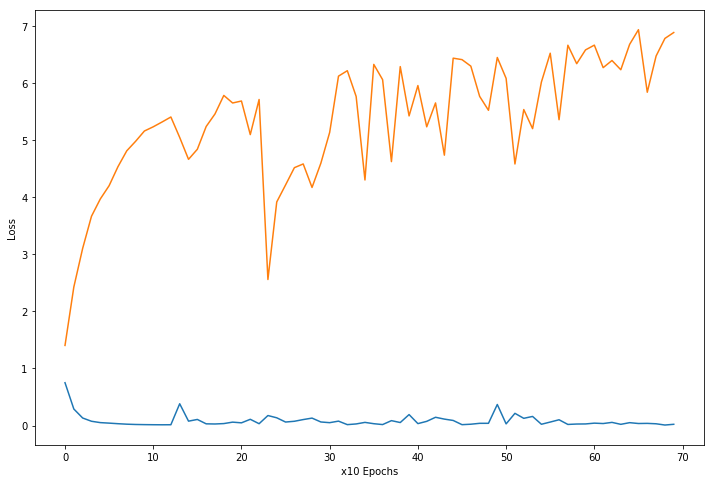

In [10]:
plt.figure(figsize=[12,8])
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.ylabel('Loss')
plt.xlabel('x10 Epochs')
plt.show()

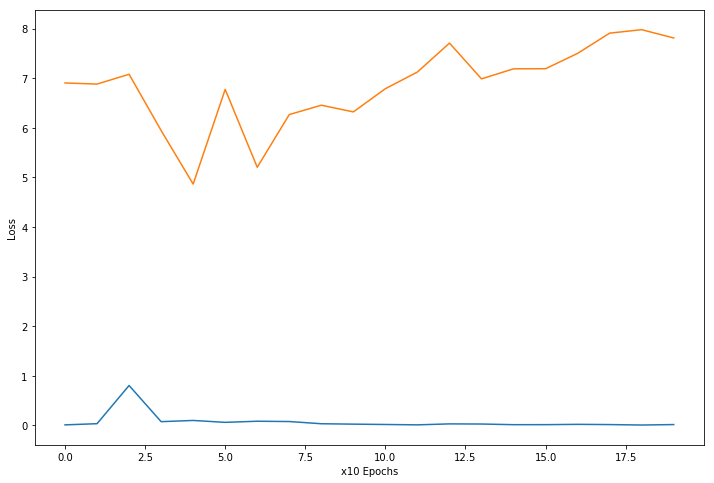

In [13]:
plt.figure(figsize=[12,8])
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.ylabel('Loss')
plt.xlabel('x10 Epochs')
plt.show()

# Mixtured Dataset to maintain Structure

In [8]:
# Train the model
total_step = len(trainloader_pixel)
d_loss_list = []
g_loss_list = []
acc_list = []
num_epochs = 1000
sample_imflag = 0

for epoch in range(num_epochs):
    
    trainiter_nonpixel = iter(trainloader_nonpixel)
    trainIter_pixel = iter(trainloader_pixel)
    
    for i in range(1):
        
        images, labels = trainIter_pixel.next()
        inputImages, input_lbls = trainiter_nonpixel.next()
        
        
        images = images.to(device)
        inputImages = inputImages.to(device)
        
        labels = torch.tensor(labels, dtype=torch.float, device=device)
        
        # Run the forward pass
        real_classification = D(images) 
        d_loss_real = criterion(real_classification, labels)
        fake_images = G(images)
        
        fake_classification = D(fake_images)
        
        fake_lbls = torch.zeros(len(labels))
        fake_lbls = fake_lbls.to(device)
        
        d_loss_fake = criterion(fake_classification, fake_lbls)
        d_loss = d_loss_real + d_loss_fake
        

        # Backprop and perform Adam optimisation for Discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        
        
        #Discriminator
        fake_lbls_duped = torch.ones(len(labels))
        fake_lbls_duped = fake_lbls_duped.to(device)
    
        fake_images = G(images)
        fake_classification = D(fake_images)
    
        #this loss denotes how well the generator duped/tricked the discriminator
        g_loss = criterion(fake_classification, fake_lbls_duped)
        
        
        
        # Backprop and perform Adam optimisation for generator
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        
      
    if (epoch+1) % 10 == 0:
        print('Epoch No [{}/{}] Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(epoch+1,num_epochs,d_loss.item(),g_loss.item()))
        #appending loss every 10 epochs
        d_loss_list.append(d_loss.item())
        g_loss_list.append(g_loss.item())
    
        # Save fake images
        fake_images = fake_images.view(fake_images.size(0), 3, 128, 128)
        save_image(fake_images.data, 'images/GAN_IO/fakes/fake_images-%d.png' %(epoch+1))
        
        
        # Save input images
        if sample_imflag == 0:
            inputImages = inputImages.view(inputImages.size(0), 3, 128, 128)
            save_image(inputImages.data, 'images/GAN_IO/input_images/inputImages-%d.png' %(epoch+1))
            sample_imflag = 1
    
#GANs are saved
torch.save(G.state_dict(), 'GAN_OUTs/DCGAN4_generator.pkl')
torch.save(D.state_dict(), 'GAN_OUTs/DCGAN4_discriminator.pkl')
    


Epoch No [10/1000] Discriminator Loss: 0.7799, Generator Loss: 2.9334
Epoch No [20/1000] Discriminator Loss: 0.7286, Generator Loss: 6.1273
Epoch No [30/1000] Discriminator Loss: 0.6818, Generator Loss: 5.0630
Epoch No [40/1000] Discriminator Loss: 0.6215, Generator Loss: 5.9237
Epoch No [50/1000] Discriminator Loss: 0.5272, Generator Loss: 6.4567
Epoch No [60/1000] Discriminator Loss: 0.3821, Generator Loss: 6.9844
Epoch No [70/1000] Discriminator Loss: 0.2108, Generator Loss: 7.0016
Epoch No [80/1000] Discriminator Loss: 0.0916, Generator Loss: 9.3416
Epoch No [90/1000] Discriminator Loss: 0.0353, Generator Loss: 13.0772
Epoch No [100/1000] Discriminator Loss: 0.0219, Generator Loss: 20.8908
Epoch No [110/1000] Discriminator Loss: 0.2275, Generator Loss: 34.2786
Epoch No [120/1000] Discriminator Loss: 0.0599, Generator Loss: 32.4003
Epoch No [130/1000] Discriminator Loss: 0.0428, Generator Loss: 22.6781
Epoch No [140/1000] Discriminator Loss: 0.0250, Generator Loss: 25.0759
Epoch No 